### PCA Analysis of the dense layers (dogs and cats dataset)

In [1]:
%matplotlib inline
path = "../data/dl1/objnc/rep/dogscats/nofinetune/"
TYPE = 'train'
#TYPE = 'valid'
threshold = 0.5
fraction = 0.9
models = ['maxpooling2d_5','dense_1','dense_2','dense_3']

In [2]:
from time import time
import os
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from utils import *
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import scipy.spatial.distance
import dimest; reload(dimest)

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


<module 'dimest' from 'dimest.pyc'>

In [3]:
D = np.load(path +  'D_sq_' + TYPE + '.npy')  

In [4]:
C = []
DimPCA = []
DimEst = []

for i in range(len(models)):
    ti = time() 
    
    # load representation and distances
    R = np.load(path + models[i] +  '_' + TYPE + '.npy')   
    R.shape = [R.shape[0],-1]
    
    # estimate dimension 
    T = dimest.estimate_dim(D[5 + i], fraction=fraction, plot_dim=False)
    DimEst.append(np.round(T[2].slope))
    
    # pca
    pca = PCA()
    pca.fit(R)
    
    # append pca results to C
    C.append(pca.explained_variance_ratio_)
       
    # find first element such that var.expl is > threshold and append to I
    c = np.cumsum(pca.explained_variance_ratio_) > threshold
    trues = np.argwhere(c==True)
    DimPCA.append(trues[0][0])
 
    print 'Space dimension : ' + str(R.shape[1]) + ' Time (s) : ' + str(time() - ti)
    del R   
    
print('PCA dimensions : ' + str(DimPCA))
print('Est dimensions : ' + str(DimEst))

Space dimension : 25088 Time (s) : 18.2165191174
Space dimension : 4096 Time (s) : 4.2443189621
Space dimension : 4096 Time (s) : 4.20484614372
Space dimension : 1000 Time (s) : 0.769559144974
PCA dimensions : [137, 54, 26, 14]
Est dimensions : [47.0, 36.0, 26.0, 5.0]


### We concentrate on one layer now : the last conv layer

We compute first its PCA, then we separately evaluate the contribution to the intrinsic dimension
given by each of the transformed components

In [41]:
R = np.load(path + models[0] +  '_' + TYPE + '.npy')   
R.shape = [R.shape[0],-1]
print R.shape

(2000, 25088)


In [42]:
pca = PCA()
R_new = pca.fit_transform(R)  
print R_new.shape

(2000, 2000)


Original Dimension = 47.3002851151


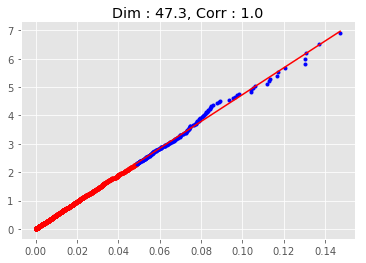

In [44]:
# Compute the original dimension

d = scipy.spatial.distance.pdist(R_new, 'euclidean')
d_sq = scipy.spatial.distance.squareform(d, force='no', checks=True)
T = dimest.estimate_dim(d_sq, fraction=fraction, plot_dim=True)
Ori_Dim = T[2].slope
print('Original Dimension = ' + str(Ori_Dim))

In [51]:
# for each principal component I compute the dimension without that component
Dim = []
idx = range(R_new.shape[1])
for i in range(50):
    ti = time()
    
    lidx = idx[:i] + idx[i+1 :]
    R_tmp = R_new[:,lidx]
    d = scipy.spatial.distance.pdist(R_tmp, 'euclidean')
    d_sq = scipy.spatial.distance.squareform(d, force='no', checks=True)
    T = dimest.estimate_dim(d_sq, fraction=fraction, plot_dim=False)   
    Dim.append(T[2].slope)
    
    te = time()
    #print(str(te-ti))

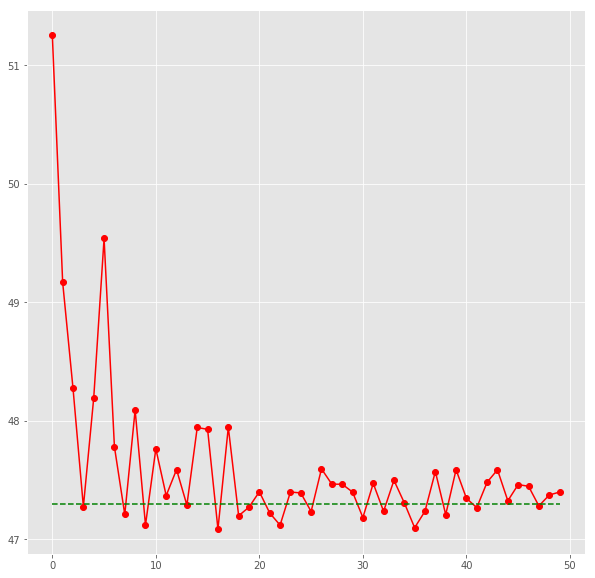

In [52]:
fig = plt.figure(figsize=(10,10))
plt.plot(Dim,'-ro')
plt.plot([0, len(Dim)-1], [Ori_Dim, Ori_Dim],'--g')
plt.show()